### Условие задачи

Участникам чемпионата предстоит создать свое решение по
прогнозированию оттока с использованием данных о клиентах. В вашем
доступе находится информация о запросах пользователей к сайтам
конкурентов и история обращений в компанию

### Описание входных значений

train.csv — файл содержащий данные пользователей для тренировки. Где:
-  1 - клиент ушел,
-  0 - остался.

log.csv — содержит данные обращения пользователей.;

named.csv — лог днс-запросов к доменам конкурентов (rt.ru и sampo.ru).

type contract.csv - тип списания у пользователей, где:
-  1 - посуточная,
-  0 - помесячная.

submission.csv — пример файла для отправки.

### Функции

In [1]:
def df_info(data):
    display(data.info(verbose=True, show_counts=True))
    display(data.head())

In [2]:
# функция для вывода матрицы корреляций\
def corr_heatmap(data, title):
    data.corr()
    plt.figure(figsize=(18,10))
    sns.set(font_scale=1.1)
    sns.heatmap(data.corr(), annot=True, square=True, cmap="PuBuGn", fmt='.2f')\
    .set_title(title)
    plt.show()

In [3]:
def df_countplot(data, x, hue):
    plt.figure(figsize=(15,5))
    sns.countplot(x=x, hue = hue,data = data)
    plt.show()

In [4]:
def hist(data, col):
    data[col].hist(figsize=(15,5))
    plt.show()

In [5]:
def boxplot(x):
    plt.figure(figsize=(15,5))
    sns.boxplot(x=x)
    plt.show()

###  Библиотеки

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from datetime import datetime

%matplotlib inline

#отлючаем уведомления от Pandas
import warnings
warnings.filterwarnings('ignore')

In [7]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

### Загрузка датасетов

In [8]:
df_train = pd.read_csv("train_dataset_train.csv")
df_sample_solution = pd.read_csv("sample_solution.csv")

df_named = pd.read_csv("named.csv")
df_type_contract = pd.read_csv("type_contract.csv")
df_log = pd.read_csv("log.csv")

### Знакомство с данными

In [9]:
df_info(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   contract_id  5992 non-null   int64
 1   blocked      5992 non-null   int64
dtypes: int64(2)
memory usage: 93.8 KB


None

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0
3,7795,0
4,7798,0


In [10]:
df_info(df_named) # лог днс-запросов к доменам конкурентов (rt.ru и sampo.ru)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10646537 entries, 0 to 10646536
Data columns (total 3 columns):
 #   Column       Non-Null Count     Dtype 
---  ------       --------------     ----- 
 0   date         10646537 non-null  object
 1   url          10646537 non-null  object
 2   contract_id  10646537 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 243.7+ MB


None

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335
3,17-Apr-2021,tvip-provision.sampo.ru,61670
4,17-Apr-2021,tvip-provision.sampo.ru,39370


In [11]:
df_info(df_log) # содержит данные обращения пользователей

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25274 entries, 0 to 25273
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   contract_id  25274 non-null  int64 
 1   event_date   25274 non-null  object
 2   event_type   25274 non-null  object
dtypes: int64(1), object(2)
memory usage: 592.5+ KB


None

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах


In [12]:
df_info(df_type_contract) # тип списания у пользователей, где: 1 - посуточная,0 - помесячная

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6805 entries, 0 to 6804
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   contract_id            6805 non-null   int64
 1   day_or_month_contract  6805 non-null   int64
dtypes: int64(2)
memory usage: 106.5 KB


None

,contract_id,day_or_month_contract
0,7780,0
1,3996,0
2,7785,0
3,7794,0
4,7795,1


In [13]:
df_info(df_sample_solution) # пример файла для отправки, id юзеров для тестовой выборки

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   contract_id  810 non-null    int64
 1   blocked      810 non-null    int64
dtypes: int64(2)
memory usage: 12.8 KB


None

,contract_id,blocked
0,3453,0
1,3454,0
2,3455,0
3,3456,0
4,3457,0


В исходных датасетах пропусков нет

### Узнаем размерность наборов

In [14]:
print("df_train", df_train.shape)
print("df_named", df_named.shape)
print("df_sample_solution", df_sample_solution.shape)
print("df_type_contract", df_type_contract.shape)
print("df_log", df_log.shape)

df_train (5992, 2)
df_named (10646537, 3)
df_sample_solution (810, 2)
df_type_contract (6805, 2)
df_log (25274, 3)


### Создадим датасет для тестовой выборки

In [15]:
df_test = df_sample_solution
df_test.head()

,contract_id,blocked
0,3453,0
1,3454,0
2,3455,0
3,3456,0
4,3457,0


### Исследуем баланс классов

In [16]:
# распределение классов по целевому признаку
df_train['blocked'].value_counts(normalize='bool')

0    0.883511
1    0.116489
Name: blocked, dtype: float64

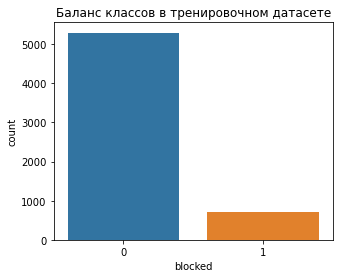

In [17]:
plt.figure(figsize=(5,4))
sns.countplot(data=df_train, x="blocked")
plt.title('Баланс классов в тренировочном датасете')
plt.xlabel('blocked')
plt.ylabel('count')
plt.show()

Классы несбалансированы по целевому признаку.

11.6% пользователей отказались от услуг оператора.

### Видоизмение данных (добавление и исследование признаков)

#### Тип списания

Обьединим два набора с данными. Для каждого пользователя добавим информацию по типу списания оплаты (1 - посуточная, 0 - помесячная).

In [18]:
df_train = pd.merge(df_train, df_type_contract , on="contract_id", how='left').drop_duplicates(subset="contract_id")
df_test = pd.merge(df_test, df_type_contract , on="contract_id", how='left').drop_duplicates(subset="contract_id")

df_train.head(3)

,contract_id,blocked,day_or_month_contract
0,7780,0,0.0
1,7785,0,0.0
2,7794,0,0.0


In [19]:
# распределение классов по типу списания оплты
df_train['day_or_month_contract'].value_counts(normalize='bool')

0.0    0.568614
1.0    0.431386
Name: day_or_month_contract, dtype: float64

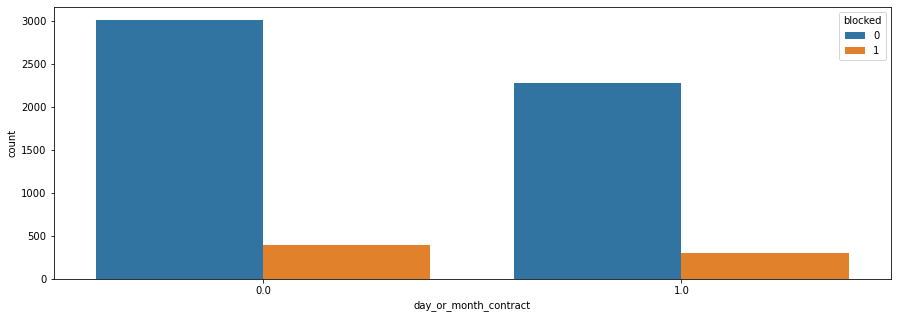

In [20]:
df_countplot(df_train, 'day_or_month_contract', 'blocked')

57% пользователей платят за услуги раз в месяц, 43% пользователя должны оплачивать услуги ежедневно.

Среди обеих групп целевых пользователей преобладают пользователи с ежемесячными списаниями.

In [21]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

#### Количество обращений (число дней обращений и число типов обращений)

Преобразуем время обращения, оставиви только дату.

In [22]:
df_log['cnt_date'] = pd.to_datetime(df_log['event_date']).dt.date
df_log.head()

,contract_id,event_date,event_type,cnt_date
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров,2021-03-28
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах,2021-03-28
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета,2021-03-28
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета,2021-03-28
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах,2021-03-28


,cnt_contacting
contract_id,
3453,1
3454,1
3456,4
3457,4
3458,23


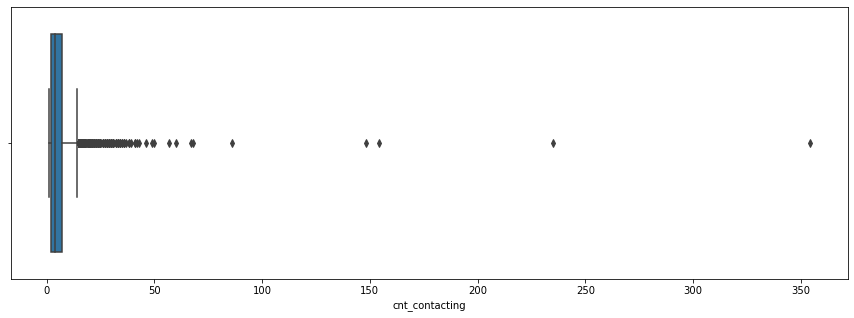

In [23]:
count_log = df_log.groupby("contract_id").agg({'event_type':'count'})
count_log = count_log.rename(columns={"event_type": "cnt_contacting"})
display(count_log.head(5))
boxplot(count_log['cnt_contacting'])

Видим длинные хвосты аномальных значений по числу обращений и числу дней обращений. Уберем из датасета аномальных пользователей.

Добавим признак в датасеты.

In [24]:
df_train = pd.merge(df_train, count_log , on="contract_id", how='left')
df_test = pd.merge(df_test, count_log , on="contract_id", how='left')

In [25]:
# пропуски заполним нулями
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

Удалим пользователей с аномальными значениями из тренировочного датасета.

In [26]:
np.percentile(df_train['cnt_contacting'], [95])

array([14.])

In [27]:
df_train = df_train[df_train['cnt_contacting'] <=14]
len(df_train)

5726

### Поводы обращений пользователей

In [28]:
df_log2 = pd.merge(df_log, df_train[['blocked', 'contract_id']] , on="contract_id", how='left')
df_log4 = df_log2.groupby(['event_type', 'blocked'],as_index=False)['contract_id'].count()

In [29]:
df_log4[df_log4['event_type'].str.contains("Вкл")].head()

,event_type,blocked,contract_id
9,Без границ бесплатно. Включение,0.0,11
10,Без границ бесплатно. Включение,1.0,3
12,Без границ платно. Включение,0.0,5
16,Виртуальное бессмертие. Включение,0.0,3
18,Включена 10% скидка,0.0,12


In [30]:
df_log4[df_log4['event_type'].str.contains("Откл")].head()

,event_type,blocked,contract_id
11,Без границ бесплатно. Отключение,0.0,11
13,Без границ платно. Отключение,0.0,3
76,Отключение автоматической активации ГП,0.0,2
77,Отключение скидки,0.0,1
78,Отключение скидки,1.0,1


Добавим признак  - включали / отключали услугу

In [31]:
df_log5 = df_log[df_log['event_type'].str.contains("Откл")]
df_log6 = df_log[df_log['event_type'].str.contains("Вкл")]

In [32]:
df_log5 = df_log5.groupby(['contract_id'])['event_type'].count().reset_index().rename(columns={"event_type": "cnt_off"})
df_log6 = df_log6.groupby(['contract_id'])['event_type'].count().reset_index().rename(columns={"event_type": "cnt_on"})

In [33]:
df_train = pd.merge(df_train, df_log5 , on="contract_id", how='left')
df_test = pd.merge(df_test, df_log5 , on="contract_id", how='left')

df_train = pd.merge(df_train, df_log6 , on="contract_id", how='left')
df_test = pd.merge(df_test, df_log6 , on="contract_id", how='left')

In [34]:
df_train.head()

,contract_id,blocked,day_or_month_contract,cnt_contacting,cnt_off,cnt_on
0,7780,0,0.0,9.0,1.0,NaN
1,7785,0,0.0,1.0,NaN,NaN
2,7794,0,0.0,0.0,NaN,NaN
3,7795,0,1.0,7.0,NaN,4.0
4,7798,0,0.0,3.0,NaN,NaN


In [35]:
# пропуски заполним нулями
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [36]:
print(len(df_train))
print(len(df_test))

5726
810


### Поводы обращения

In [37]:
df_log4[df_log4['blocked']==1].sort_values(by='contract_id', ascending=False).head(7)

,event_type,blocked,contract_id
67,Информер ВК. Показ,1.0,558
72,Обращение в службу заботы о клиентах,1.0,374
29,Включение интернета на 20 минут,1.0,315
49,Гарантированный платеж за деньги,1.0,206
70,Оборудование,1.0,66
41,Внутреннее сообщение,1.0,61
31,Включение интернета на 20 минут с IVR,1.0,56


In [38]:
df_log4[df_log4['blocked']==0].sort_values(by='contract_id', ascending=False).head(7)

,event_type,blocked,contract_id
66,Информер ВК. Показ,0.0,5414
28,Включение интернета на 20 минут,0.0,1857
71,Обращение в службу заботы о клиентах,0.0,1649
48,Гарантированный платеж за деньги,0.0,1192
136,Турбокнопка бесплатно,0.0,193
129,Смена тарифа,0.0,186
131,Состояние клиентского оборудования,0.0,169


In [39]:
log1 = df_log[df_log['event_type'].str.contains('Информер ВК. Показ')]
log1['vk'] = 1
log2 = log1.groupby(['contract_id'])['vk'].max().reset_index()
df_train = pd.merge(df_train, log2, on="contract_id", how='left')
df_test = pd.merge(df_test, log2 , on="contract_id", how='left')

In [40]:
log1 = df_log[df_log['event_type'].str.contains('Обращение в службу заботы о клиентах')]
log1['care'] = 1
log2 = log1.groupby(['contract_id'])['care'].max().reset_index()
df_train = pd.merge(df_train, log2, on="contract_id", how='left')
df_test = pd.merge(df_test, log2 , on="contract_id", how='left')

In [41]:
log1 = df_log[df_log['event_type'].str.contains('Гарантированный платеж за деньги')]
log1['garant_pay'] = 1
log2 = log1.groupby(['contract_id'])['garant_pay'].max().reset_index()
df_train = pd.merge(df_train, log2, on="contract_id", how='left')
df_test = pd.merge(df_test, log2 , on="contract_id", how='left')

In [42]:
log1 = df_log[df_log['event_type'].str.contains('Оборудование')]
log1['equipment'] = 1
log2 = log1.groupby(['contract_id'])['equipment'].max().reset_index()
df_train = pd.merge(df_train, log2, on="contract_id", how='left')
df_test = pd.merge(df_test, log2 , on="contract_id", how='left')

In [43]:
log1 = df_log[df_log['event_type'].str.contains('Турбокнопка платно')]
log1['turbo'] = 1
log2 = log1.groupby(['contract_id'])['turbo'].max().reset_index()
df_train = pd.merge(df_train, log2 , on="contract_id", how='left')
df_test = pd.merge(df_test, log2 , on="contract_id", how='left')

In [44]:
# пропуски заполним нулями
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [45]:
print(len(df_train))
print(len(df_test))

5726
810


### Логи запросов к доменам конкурентов

In [46]:
named = pd.merge(df_named, df_train[['blocked', 'contract_id']] , on="contract_id", how='left')
named = named.groupby(['url', 'blocked'],as_index=False)['contract_id'].count()

In [47]:
named[named['blocked']==1].sort_values(by=['contract_id'], ascending=False).head(10)

,url,blocked,contract_id
572,vmx.svc.iptv.rt.ru,1.0,246
286,moigorod.sampo.ru,1.0,115
148,fnc.rt.ru,1.0,113
504,swap.sampo.ru,1.0,105
446,st44-broadcast.sampo.ru,1.0,105
399,sampo.ru,1.0,93
265,lk.sampo.ru,1.0,91
139,fe-nw.svc.iptv.rt.ru,1.0,87
388,rt-static.rt.ru,1.0,86
346,petrozavodsk.speedtest.rt.ru.prod.hosts.ooklas...,1.0,86


In [48]:
named[named['blocked']==0].sort_values(by=['contract_id'], ascending=False).head(10)

,url,blocked,contract_id
573,vmxott.svc.iptv.rt.ru,0.0,6857
285,moigorod.sampo.ru,0.0,5488
324,ohrana.sampo.ru,0.0,4704
445,st44-broadcast.sampo.ru,0.0,4643
147,fnc.rt.ru,0.0,4525
507,sz-mrsk-itv01.svc.iptv.rt.ru,0.0,4480
449,st46-broadcast.sampo.ru,0.0,3597
502,sus.sampo.ru,0.0,3205
566,vhod.sampo.ru,0.0,3021
508,sz-mrsk-itv02.svc.iptv.rt.ru,0.0,2968


In [49]:
name1 = df_named[df_named['url'].str.contains('iptv.rt.ru')]
name1['iptv'] = 1
name2 = name1.groupby(['contract_id'])['iptv'].max().reset_index()
df_train = pd.merge(df_train, name2, on="contract_id", how='left')
df_test = pd.merge(df_test, name2 , on="contract_id", how='left')

In [50]:
name1 = df_named[df_named['url'].str.contains('moigorod.sampo.ru')]
name1['moigorod'] = 1
name2 = name1.groupby(['contract_id'])['moigorod'].max().reset_index()
df_train = pd.merge(df_train, name2, on="contract_id", how='left')
df_test = pd.merge(df_test, name2 , on="contract_id", how='left')

In [51]:
name1 = df_named[df_named['url'].str.contains('fnc.rt.ru')]
name1['fnc'] = 1
name2 = name1.groupby(['contract_id'])['fnc'].max().reset_index()
df_train = pd.merge(df_train, name2, on="contract_id", how='left')
df_test = pd.merge(df_test, name2 , on="contract_id", how='left')

In [52]:
name1 = df_named[df_named['url'].str.contains('swap.sampo.ru')]
name1['swap'] = 1
name2 = name1.groupby(['contract_id'])['swap'].max().reset_index()
df_train = pd.merge(df_train, name2, on="contract_id", how='left')
df_test = pd.merge(df_test, name2 , on="contract_id", how='left')

In [53]:
name1 = df_named[df_named['url'].str.contains('ohrana.sampo.ru')]
name1['ohrana'] = 1
name2 = name1.groupby(['contract_id'])['ohrana'].max().reset_index()
df_train = pd.merge(df_train, name2, on="contract_id", how='left')
df_test = pd.merge(df_test, name2 , on="contract_id", how='left')

In [54]:
name1 = df_named[df_named['url'].str.contains('broadcast.sampo.ru')]
name1['broadcast'] = 1
name2 = name1.groupby(['contract_id'])['broadcast'].max().reset_index()
df_train = pd.merge(df_train, name2, on="contract_id", how='left')
df_test = pd.merge(df_test, name2 , on="contract_id", how='left')

In [55]:
name1 = df_named[df_named['url'].str.contains('speedtest')]
name1['speedtest'] = 1
name2 = name1.groupby(['contract_id'])['speedtest'].max().reset_index()
df_train = pd.merge(df_train, name2, on="contract_id", how='left')
df_test = pd.merge(df_test, name2 , on="contract_id", how='left')

In [56]:
print(len(df_train))
print(len(df_test))

5726
810


#### К какому домену конкурентов обращались пользователи

Посмотрим к каким доменам обращались пользователи. Подсчитаем общее число обращений и число доменов, к которым пользователь обращался.

In [57]:
df_named['rt'] = np.where(df_named['url'].str.contains('.rt.'), 'rt', 'sampo')
df_named['is_rt'] = np.where(df_named['url'].str.contains('.rt.'), 1, 0)
df_named['is_sampo'] = np.where(df_named['url'].str.contains('.sampo.'), 1, 0)

In [58]:
df_named['cnt_domen'] = df_named['is_sampo']+df_named['is_rt']

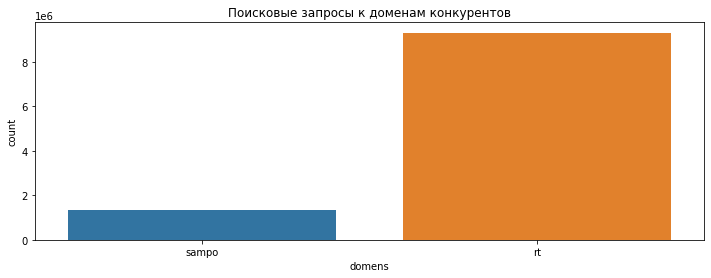

In [59]:
plt.figure(figsize=(12,4))
sns.countplot(data=df_named, x="rt")
plt.title('Поисковые запросы к доменам конкурентов')
plt.xlabel('domens')
plt.ylabel('count')
plt.show()

Большая часть запросов приходится на домены Ростелекома

#### Количество запросов к доменам конкурентов

In [60]:
count_named = df_named.groupby(["contract_id"], as_index=False)['url'].count()
count_named.head()

,contract_id,url
0,3455,24
1,3458,1
2,3459,2
3,3460,10
4,3461,1


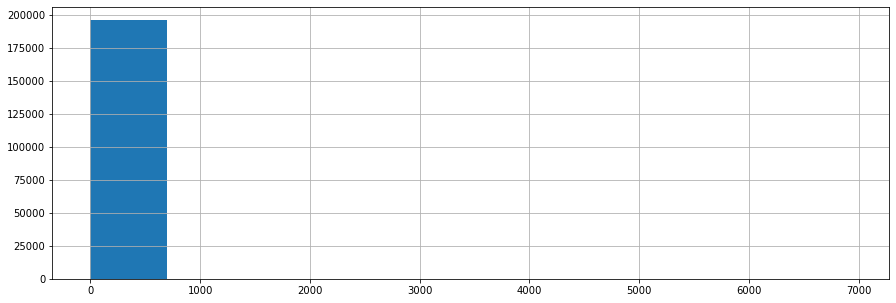

In [61]:
hist(count_named, 'url')

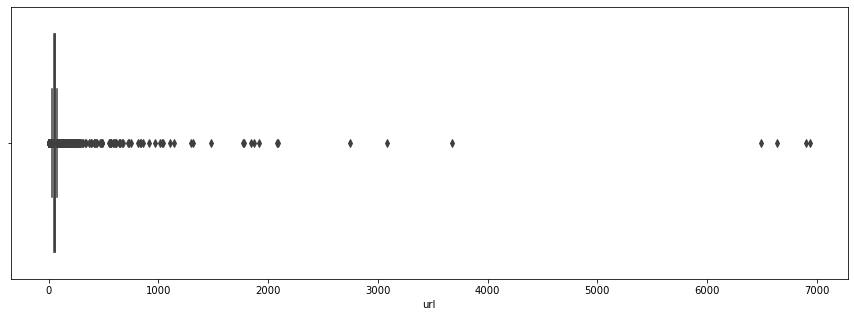

In [62]:
boxplot(count_named['url'])

На диаграмме видим, что большая часть значений признака (число зпросов к доменам конкурентов) находится в довоьлно узком диапазоне. Откинем пользователей из тренировочного датасета. с аномальными значениями.

In [63]:
df_train = pd.merge(df_train, count_named, on="contract_id", how='left')
df_test = pd.merge(df_test, count_named, on="contract_id", how='left')

In [64]:
# пропуски заполним нулями
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [65]:
np.percentile(df_train['url'], [95])

array([56.])

In [66]:
df_train = df_train[df_train['url'] <=56]
len(df_train)

5442

#### Число доменов конкурентов

In [67]:
df_named.head()

,date,url,contract_id,rt,is_rt,is_sampo,cnt_domen
0,17-Apr-2021,webmail.sampo.ru,101397,sampo,0,1,1
1,17-Apr-2021,webmail.sampo.ru,179624,sampo,0,1,1
2,17-Apr-2021,tvip-provision.sampo.ru,190335,sampo,0,1,1
3,17-Apr-2021,tvip-provision.sampo.ru,61670,sampo,0,1,1
4,17-Apr-2021,tvip-provision.sampo.ru,39370,sampo,0,1,1


In [68]:
cnt_domen = df_named.groupby(['contract_id'], as_index=False)['is_sampo', 'is_rt'].max()
cnt_domen['cnt_domen'] = cnt_domen['is_sampo']+cnt_domen['is_rt']

In [69]:
df_train = pd.merge(df_train, cnt_domen[['contract_id','cnt_domen']] , on="contract_id", how='left')
df_test = pd.merge(df_test, cnt_domen[['contract_id','cnt_domen']] , on="contract_id", how='left')

In [70]:
# пропуски заполним нулями
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [71]:
df_train['cnt_domen'].value_counts()

0.0    2962
1.0    1462
2.0    1018
Name: cnt_domen, dtype: int64

### Среднее число обращений в поддержку в день

In [72]:
df_log.head()

,contract_id,event_date,event_type,cnt_date
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров,2021-03-28
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах,2021-03-28
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета,2021-03-28
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета,2021-03-28
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах,2021-03-28


In [73]:
df_support_1 = df_log.groupby(['contract_id', 'cnt_date'], as_index=False)['event_date'].count()
df_support_1.head()

,contract_id,cnt_date,event_date
0,3453,2021-03-03,1
1,3454,2021-04-28,1
2,3456,2021-03-21,4
3,3457,2021-03-09,1
4,3457,2021-03-10,1


In [74]:
df_support_2 = df_support_1.groupby(['contract_id'], as_index=False)['event_date'].median()
df_support_2 = df_support_2.rename(columns={"event_date": "avg_support"})
df_support_2.head()

,contract_id,avg_support
0,3453,1.0
1,3454,1.0
2,3456,4.0
3,3457,1.0
4,3458,1.0


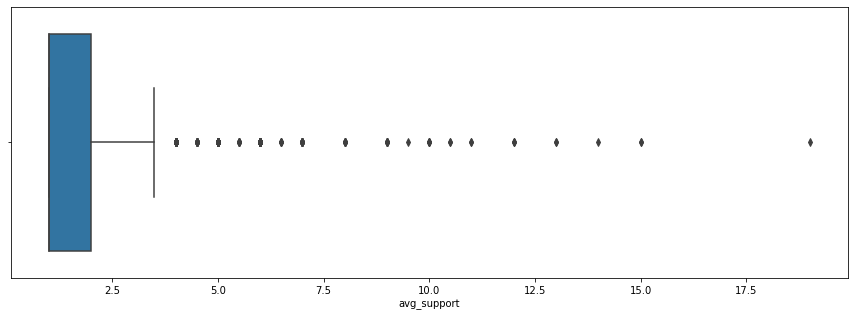

In [75]:
boxplot(df_support_2['avg_support'])

In [76]:
df_train = pd.merge(df_train, df_support_2[['contract_id','avg_support']] , on="contract_id", how='left')
df_test = pd.merge(df_test, df_support_2[['contract_id','avg_support']] , on="contract_id", how='left')

# пропуски заполним нулями
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [77]:
np.percentile(df_train['avg_support'], [95])

array([3.])

In [78]:
df_train = df_train[df_train['avg_support'] <=3]
len(df_train)

5189

### Проверка тренировочного датасета после добавления столбцов

Заменим пропуски

In [79]:
df_train = df_train.fillna(0)

In [80]:
df_train.head()

,contract_id,blocked,day_or_month_contract,cnt_contacting,cnt_off,cnt_on,vk,care,garant_pay,equipment,...,iptv,moigorod,fnc,swap,ohrana,broadcast,speedtest,url,cnt_domen,avg_support
0,7785,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,2.0,1.0
1,7794,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7795,0,1.0,7.0,0.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
3,7798,0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
4,7799,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [81]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5189 entries, 0 to 5441
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   contract_id            5189 non-null   int64  
 1   blocked                5189 non-null   int64  
 2   day_or_month_contract  5189 non-null   float64
 3   cnt_contacting         5189 non-null   float64
 4   cnt_off                5189 non-null   float64
 5   cnt_on                 5189 non-null   float64
 6   vk                     5189 non-null   float64
 7   care                   5189 non-null   float64
 8   garant_pay             5189 non-null   float64
 9   equipment              5189 non-null   float64
 10  turbo                  5189 non-null   float64
 11  iptv                   5189 non-null   float64
 12  moigorod               5189 non-null   float64
 13  fnc                    5189 non-null   float64
 14  swap                   5189 non-null   float64
 15  ohra

### Проверка тестового датасета после добавления столбцов

In [82]:
df_test = df_test.fillna(0)
df_test.head()

,contract_id,blocked,day_or_month_contract,cnt_contacting,cnt_off,cnt_on,vk,care,garant_pay,equipment,...,iptv,moigorod,fnc,swap,ohrana,broadcast,speedtest,url,cnt_domen,avg_support
0,3453,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3454,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3455,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,24.0,2.0,0.0
3,3456,0,0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,3457,0,0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [83]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 810 entries, 0 to 809
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   contract_id            810 non-null    int64  
 1   blocked                810 non-null    int64  
 2   day_or_month_contract  810 non-null    int64  
 3   cnt_contacting         810 non-null    float64
 4   cnt_off                810 non-null    float64
 5   cnt_on                 810 non-null    float64
 6   vk                     810 non-null    float64
 7   care                   810 non-null    float64
 8   garant_pay             810 non-null    float64
 9   equipment              810 non-null    float64
 10  turbo                  810 non-null    float64
 11  iptv                   810 non-null    float64
 12  moigorod               810 non-null    float64
 13  fnc                    810 non-null    float64
 14  swap                   810 non-null    float64
 15  ohrana

### Распределение признаков

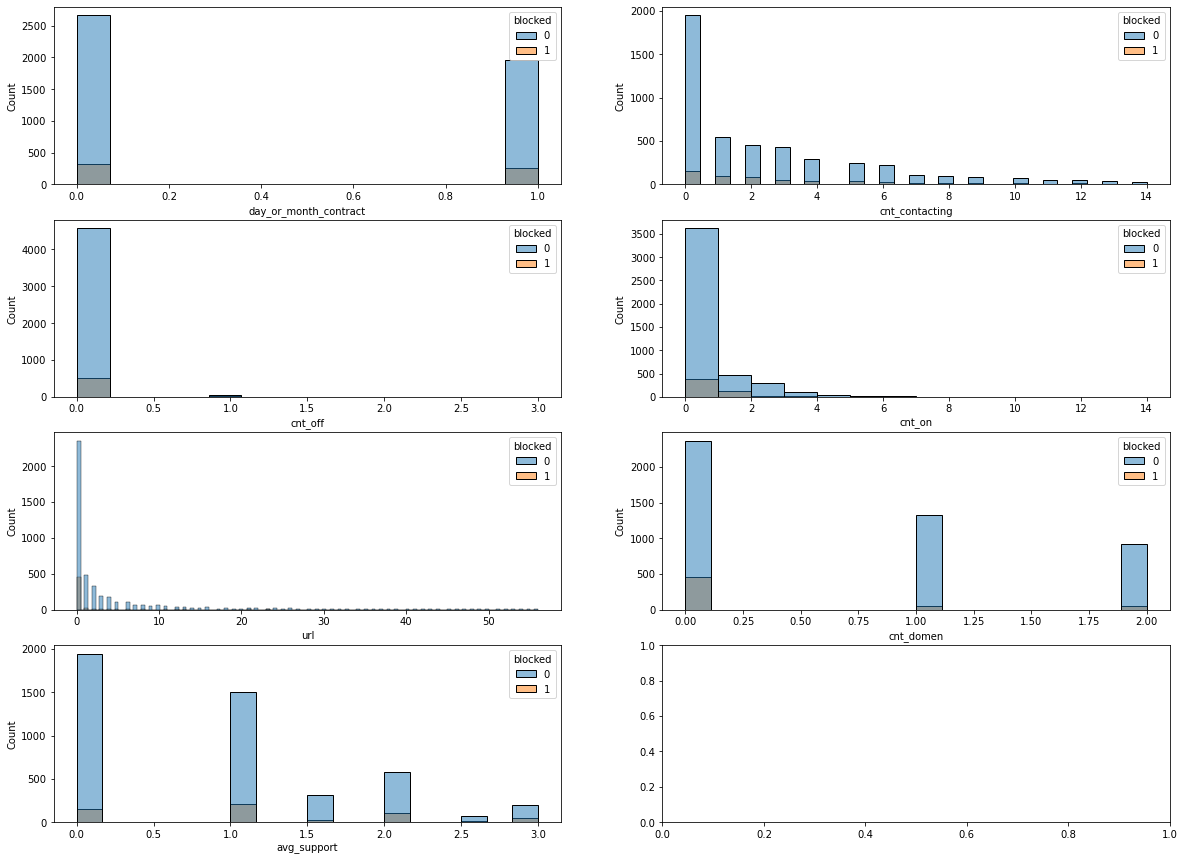

In [84]:
# распределение количественных признаков
try:
    fig, ax = plt.subplots(4, 2, figsize=(20, 15))
    sns.histplot(x='day_or_month_contract', hue = 'blocked',data = df_train, ax=ax[0][0])
    sns.histplot(x='cnt_contacting', hue = 'blocked',data = df_train, ax=ax[0][1])
    sns.histplot(x='cnt_off', hue = 'blocked',data = df_train, ax=ax[1][0])
    sns.histplot(x='cnt_on', hue = 'blocked',data = df_train, ax=ax[1][1])
    sns.histplot(x='url', hue = 'blocked',data = df_train, ax=ax[2][0])
    sns.histplot(x='cnt_domen', hue = 'blocked',data = df_train, ax=ax[2][1])
    sns.histplot(x='avg_support', hue = 'blocked',data = df_train, ax=ax[3][0])
    plt.show()
except:
    print('Вывод визуализаций невозможен, необходимо перезапустить ноутбук повторно.')

### Проверка на мультиколлениарность

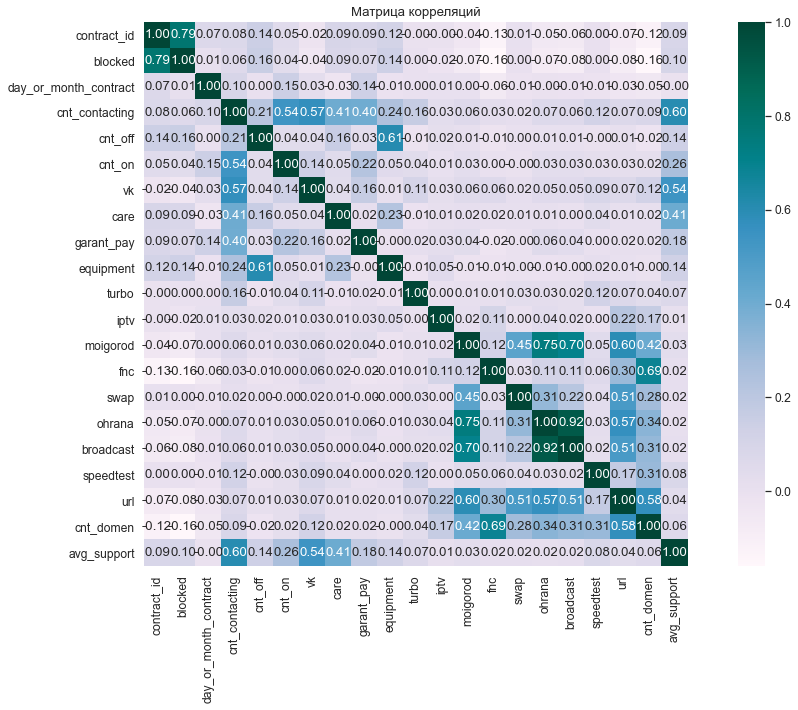

In [85]:
corr_heatmap(df_train, 'Матрица корреляций')

In [86]:
cols_to_drop = ['cnt_domen', 'url', 'cnt_off', 'cnt_contacting', 'ohrana', 'fnc', 'turbo', 'speedtest']
df_train = df_train[df_train.columns.drop(cols_to_drop)]
df_test = df_test[df_test.columns.drop(cols_to_drop)]

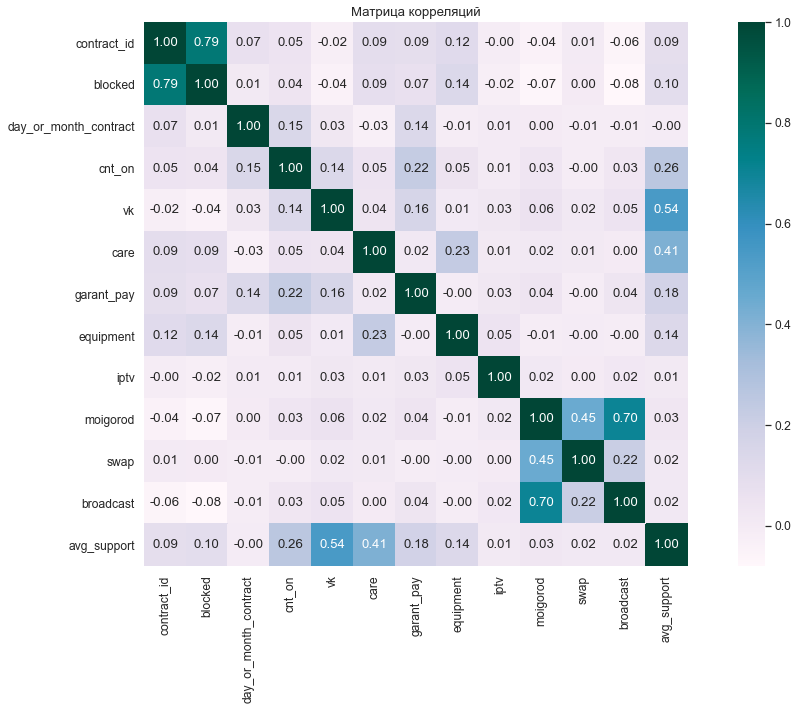

In [87]:
corr_heatmap(df_train, 'Матрица корреляций')

### Разделение исходных данных  на обучающую, валидационную выборки (тестовая же в отдельном датасете)

In [88]:
df_train.head()

,contract_id,blocked,day_or_month_contract,cnt_on,vk,care,garant_pay,equipment,iptv,moigorod,swap,broadcast,avg_support
0,7785,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7794,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7795,0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
3,7798,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
4,7799,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X_train_full = df_train.drop(["contract_id", "blocked"], axis = 1)
y_train_full = df_train[["blocked"]]

X_test = df_test.drop(["contract_id", "blocked"], axis = 1)
y_test = df_test[["blocked"]]

In [90]:
# созддим переменную под параметр random_state
rs = 42

In [91]:
# Из обучающей выборки выделим валидационную выборку
X_train, X_val, y_train, y_val =\
train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=rs, stratify=y_train_full)

### Масштабирование признаков

Поскольку в данных присутствуют признаки с большими значениями и большим разбросом данных (вычисляемые столбцы, которые мы добавили - cnt_contacting, url), то алгоритмы машинного обучения могут решить, что при обучении такие признаки являются более значимыми. Чтобы избежать подобной проблемы, необходимо масштабировать данные (привести в единую шкалу).

Стандартизируем численные признаки обучающей выборки, которые имеют большой разброс данных. 

Данную процедуру пройдут все выборки, которые будут использованы.

In [92]:
X_train_full.describe()

,day_or_month_contract,cnt_on,vk,care,garant_pay,equipment,iptv,moigorod,swap,broadcast,avg_support
count,5189.000000,5189.000000,5189.000000,5189.000000,5189.000000,5189.000000,5189.000000,5189.000000,5189.000000,5189.000000,5189.000000
mean,0.426094,0.460975,0.348622,0.184621,0.123531,0.016574,0.028329,0.096550,0.038158,0.067258,0.881576
std,0.494555,1.152195,0.476580,0.388027,0.329077,0.127679,0.165927,0.295373,0.191595,0.250492,0.877905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000
max,1.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [93]:
from sklearn.preprocessing import StandardScaler

numeric = ['cnt_on', 'avg_support']

scaler = StandardScaler()
scaler.fit(X_train[numeric])

X_train_full[numeric] = scaler.transform(X_train_full[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_val[numeric] = scaler.transform(X_val[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

display(X_train.head())

,day_or_month_contract,cnt_on,vk,care,garant_pay,equipment,iptv,moigorod,swap,broadcast,avg_support
3888,1.0,-0.403212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122104
2401,1.0,2.154775,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.694524
1899,1.0,-0.403212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.022735
2134,1.0,-0.403212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.022735
3240,0.0,-0.403212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.022735


## ML

### CatBoostClassifier

In [94]:
 parameters = {'depth'         : [2,3,4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.03,0.05, 0.1, 0.3, 0.5, 0.7, 0.9],
                  'iterations'    : [70, 100, 120, 150, 170, 200]
                 }

In [95]:
# определение весов целевого класса 
from sklearn.utils import class_weight
cw = list(class_weight.compute_class_weight('balanced',
                                             np.unique(df_train['blocked']),
                                             df_train['blocked']))
cw

[0.5615800865800866, 4.559753954305799]

In [96]:
CBC = CatBoostClassifier(random_seed=42,class_weights = (0.56, 4.56), eval_metric='Recall')

In [97]:
from sklearn.model_selection import GridSearchCV
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 5, n_jobs=-1)
Grid_CBC.fit(X_train_full, y_train_full)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

0:	learn: 0.3708260	total: 138ms	remaining: 27.4s
1:	learn: 0.5518453	total: 141ms	remaining: 14s
2:	learn: 0.5940246	total: 150ms	remaining: 9.85s
3:	learn: 0.5957821	total: 154ms	remaining: 7.56s
4:	learn: 0.5957821	total: 157ms	remaining: 6.13s
5:	learn: 0.6133568	total: 162ms	remaining: 5.25s
6:	learn: 0.6186292	total: 169ms	remaining: 4.67s
7:	learn: 0.6186292	total: 172ms	remaining: 4.12s
8:	learn: 0.6256591	total: 175ms	remaining: 3.71s
9:	learn: 0.6326889	total: 178ms	remaining: 3.38s
10:	learn: 0.6485062	total: 182ms	remaining: 3.13s
11:	learn: 0.6309315	total: 186ms	remaining: 2.91s
12:	learn: 0.6379613	total: 199ms	remaining: 2.87s
13:	learn: 0.6397188	total: 202ms	remaining: 2.68s
14:	learn: 0.6414763	total: 214ms	remaining: 2.64s
15:	learn: 0.6432337	total: 227ms	remaining: 2.61s
16:	learn: 0.6520211	total: 230ms	remaining: 2.47s
17:	learn: 0.6520211	total: 233ms	remaining: 2.35s
18:	learn: 0.6520211	total: 238ms	remaining: 2.26s
19:	learn: 0.6467487	total: 245ms	remaining

175:	learn: 0.6432337	total: 1.43s	remaining: 195ms
176:	learn: 0.6432337	total: 1.43s	remaining: 186ms
177:	learn: 0.6432337	total: 1.44s	remaining: 178ms
178:	learn: 0.6449912	total: 1.46s	remaining: 171ms
179:	learn: 0.6449912	total: 1.46s	remaining: 162ms
180:	learn: 0.6449912	total: 1.46s	remaining: 153ms
181:	learn: 0.6449912	total: 1.46s	remaining: 145ms
182:	learn: 0.6449912	total: 1.47s	remaining: 137ms
183:	learn: 0.6449912	total: 1.48s	remaining: 129ms
184:	learn: 0.6449912	total: 1.49s	remaining: 120ms
185:	learn: 0.6449912	total: 1.5s	remaining: 113ms
186:	learn: 0.6449912	total: 1.5s	remaining: 104ms
187:	learn: 0.6449912	total: 1.5s	remaining: 96ms
188:	learn: 0.6449912	total: 1.52s	remaining: 88.3ms
189:	learn: 0.6432337	total: 1.53s	remaining: 80.5ms
190:	learn: 0.6432337	total: 1.53s	remaining: 72.3ms
191:	learn: 0.6432337	total: 1.55s	remaining: 64.4ms
192:	learn: 0.6432337	total: 1.55s	remaining: 56.2ms
193:	learn: 0.6432337	total: 1.55s	remaining: 48ms
194:	learn: 

Обучим модель на тренировочных данных.

In [98]:
model = CatBoostClassifier(
    iterations=200,
    random_seed=42,
    learning_rate=0.03,
    class_weights = (0.56, 4.56),
    #early_stopping_rounds= 100,
    eval_metric='Recall',
    depth=10
)

model.fit(X_train_full, y_train_full,
         eval_set=(X_val, y_val),
          verbose=30,
          plot=False
)
predictions_valid_cb = model.predict(X_val)
recall_cb = recall_score(y_val, predictions_valid_cb, average='macro')
auc_roc_cb = roc_auc_score(y_val, predictions_valid_cb)
print('recall_score CatBoostClassifier:', round(recall_cb,2))
print('auc_roc_cb CatBoostClassifier:', round(auc_roc_cb,2))

0:	learn: 0.3708260	test: 0.3943662	best: 0.3943662 (0)	total: 2.44ms	remaining: 487ms
30:	learn: 0.6485062	test: 0.6901408	best: 0.6971831 (10)	total: 198ms	remaining: 1.08s
60:	learn: 0.6379613	test: 0.6690141	best: 0.6971831 (10)	total: 496ms	remaining: 1.13s
90:	learn: 0.6379613	test: 0.6690141	best: 0.6971831 (10)	total: 723ms	remaining: 867ms
120:	learn: 0.6432337	test: 0.6690141	best: 0.6971831 (10)	total: 950ms	remaining: 620ms
150:	learn: 0.6379613	test: 0.6690141	best: 0.6971831 (10)	total: 1.14s	remaining: 370ms
180:	learn: 0.6449912	test: 0.6760563	best: 0.6971831 (10)	total: 1.35s	remaining: 142ms
199:	learn: 0.6414763	test: 0.6690141	best: 0.6971831 (10)	total: 1.47s	remaining: 0us

bestTest = 0.6971830986
bestIteration = 10

Shrink model to first 11 iterations.
recall_score CatBoostClassifier: 0.68
auc_roc_cb CatBoostClassifier: 0.68


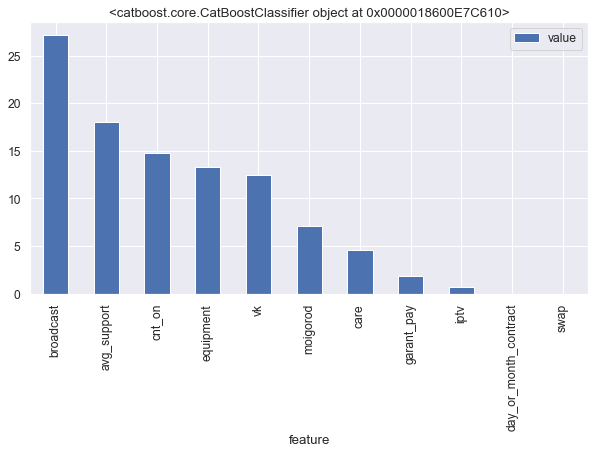

In [99]:
df_feature_importance = pd.DataFrame({'feature': X_train.columns.values, 'value': model.feature_importances_})
df_feature_importance = df_feature_importance.set_index(['feature'])
df_feature_importance = df_feature_importance.sort_values(by='value', ascending=False)
df_feature_importance.plot(kind = 'bar', title= model, figsize=(10,5))
plt.show()

Обучим финальную модель.

In [100]:
model = CatBoostClassifier(
    iterations=200,
    random_seed=42,
    learning_rate=0.03,
    class_weights = (0.56, 4.56),
    #early_stopping_rounds= 100,
    eval_metric='Recall',
    depth=10
)

model.fit(X_train_full, y_train_full,
         eval_set=(X_val, y_val),
          verbose=30,
          plot=False
)
predictions_valid_cb = model.predict(X_test)
recall_cb = recall_score(y_test, predictions_valid_cb, average='macro')
print('recall_score CatBoostClassifier:', round(recall_cb,2))

0:	learn: 0.3708260	test: 0.3943662	best: 0.3943662 (0)	total: 3.09ms	remaining: 616ms
30:	learn: 0.6485062	test: 0.6901408	best: 0.6971831 (10)	total: 196ms	remaining: 1.07s
60:	learn: 0.6379613	test: 0.6690141	best: 0.6971831 (10)	total: 518ms	remaining: 1.18s
90:	learn: 0.6379613	test: 0.6690141	best: 0.6971831 (10)	total: 713ms	remaining: 854ms
120:	learn: 0.6432337	test: 0.6690141	best: 0.6971831 (10)	total: 916ms	remaining: 598ms
150:	learn: 0.6379613	test: 0.6690141	best: 0.6971831 (10)	total: 1.12s	remaining: 365ms
180:	learn: 0.6449912	test: 0.6760563	best: 0.6971831 (10)	total: 1.32s	remaining: 139ms
199:	learn: 0.6414763	test: 0.6690141	best: 0.6971831 (10)	total: 1.44s	remaining: 0us

bestTest = 0.6971830986
bestIteration = 10

Shrink model to first 11 iterations.
recall_score CatBoostClassifier: 0.29
